In [ ]:
## sampling 
## good enough analysis 
## partition RDD

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, date_format, dayofweek, month, count, avg, max, min, to_date, to_timestamp, sum, when, dayofweek

In [4]:
spark = SparkSession.builder.appName('App')\
        .config("spark.executor.cores",'16')\
        .config("spark.executor.memory", '60g')\
        .getOrCreate()


### Read data part 1

#### Due to the very large data volume, we only choose the data from May 3 to May 9 of the years in 2019, 2020 and 2021

In [3]:
df2019May = spark.read.csv("gs://project_hyrn/2019_Yellow_Taxi_Trip_May3-9.csv")
df2020May = spark.read.csv("gs://project_hyrn/2020_Yellow_Taxi_Trip_May3-9.csv")
df2021May = spark.read.csv("gs://project_hyrn/2021_Yellow_Taxi_Trip_May3-9.csv")

In [4]:
df2021May = df2021May.withColumn("year", lit(2021))
df2020May = df2021May.withColumn("year", lit(2020))
df2019May = df2021May.withColumn("year", lit(2019))

In [5]:
union_df_May = df2021May.union(df2020May).union(df2019May)
print(union_df_May.count(),len(union_df_May.columns))

1695333 19


### Read data part 2

#### Here, we read the full dataset of year 2021

In [5]:
df2021 = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hyrn/2021_Yellow_Taxi_Trip_Data_full.csv")

In [7]:
df2020 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2020_Yellow_Taxi_Trip_Data_full.csv")

In [8]:
df2019 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2019_Yellow_Taxi_Trip_Data_full.csv")

In [9]:
sampled_2021 = df2021.sample(fraction=0.001, seed=12)
sampled_2020 = df2020.sample(fraction=0.001, seed=34)
sampled_2019 = df2019.sample(fraction=0.001, seed=56)



In [10]:
sampled_2021 = sampled_2021.withColumn("Datayear", lit(2021))
sampled_2020 = sampled_2020.withColumn("Datayear", lit(2020))
sampled_2019 = sampled_2019.withColumn("Datayear", lit(2019))

In [11]:
print(sampled_2021 .count(),len(sampled_2021 .columns))

30739 19


In [12]:
sampled_2021.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)



In [13]:
sampled_2021 .show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|       2|01/01/2021 01:56:...| 01/01/2021 02:08:...|              1|          5.1|         1|                 N|         141|         246|           1|       16.5|  0.5|    0.5|      5.08|       

In [14]:
union_df = sampled_2021.union(sampled_2020).union(sampled_2019)

### Feature Engineering 

In [15]:
# change to date type
union_df = union_df.withColumn("parsed_pickup_datetime", to_timestamp("tpep_pickup_datetime", "MM/dd/yyyy hh:mm:ss a"))
union_df = union_df.withColumn("parsed_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "MM/dd/yyyy hh:mm:ss a"))

In [16]:
union_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)



In [17]:
# calcualte average spent per mile and avergae spent per min
union_df = union_df.withColumn("PerMile", col("total_amount") / col("trip_distance"))

#df2021Full = df2021Full.withColumn("Dur",  col("parsed_dropoff_datetime") - col("parsed_pickup_datetime"))
from pyspark.sql.functions import datediff, minute, hour
union_df = union_df.withColumn("Dur", datediff("parsed_dropoff_datetime", "parsed_pickup_datetime") * 24 * 60 +hour("parsed_dropoff_datetime")* 60-hour("parsed_pickup_datetime")*60
+ minute("parsed_dropoff_datetime") - minute("parsed_pickup_datetime"))

union_df = union_df.withColumn("PerMin", col("total_amount") / col("Dur"))

In [18]:
union_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+----------------------+-----------------------+------------------+---+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|parsed_pickup_datetime|parsed_dropoff_datetime|           PerMile|Dur|            PerMin|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+-------------------

In [19]:
Avg_Spent_vendor = union_df.groupBy("VendorID") \
                           .agg(avg("PerMile").alias("Avg spent per mile"),avg("PerMin").alias("Avg spent per min")) \
                           .orderBy(col("Avg spent per mile").desc()) 
                           
Avg_Spent_vendor.show()
# vendor 4 is the most expensive provider

+--------+------------------+------------------+
|VendorID|Avg spent per mile| Avg spent per min|
+--------+------------------+------------------+
|       4|14.026552991298622|1.7817683151930406|
|       2|12.012380829529848|1.6633086830868171|
|       1|10.058146273949825|1.6875973838635543|
|       6| 9.372396361070372|0.7723514492753624|
|    null|  9.10313800315289|1.7684824945127386|
+--------+------------------+------------------+



In [20]:
# Extract the hour from pickup time
union_df = union_df.withColumn("pickup_hour", hour("parsed_pickup_datetime"))

In [21]:
Avg_Spent_hour = union_df.groupBy("pickup_hour") \
                           .agg(avg("PerMile").alias("Avg spent per mile"),avg("PerMin").alias("Avg spent per min")) \
                           .orderBy(col("pickup_hour").desc()) 
                           


In [27]:
Avg_Spent_hour.show()

+-----------+-------------------+------------------+
|pickup_hour| Avg spent per mile| Avg spent per min|
+-----------+-------------------+------------------+
|         23|  11.20857407543402|1.8112559547605147|
|         22| 10.896675433347665|1.7917601506993779|
|         21|   9.36978271953886|1.6793717633033751|
|         20|   9.69147183229511|1.6836634433395896|
|         19|  12.14714615351122|1.7116759068766247|
|         18|  10.34845594083338|1.6650377348905612|
|         17| 12.626507926367637|1.6069187271902103|
|         16| 15.704276803826557|1.6872875068753552|
|         15| 10.006299584360153|1.4945591942162584|
|         14| 12.064021714189552|1.5509777511013487|
|         13| 11.394626650673084|1.5298018606839785|
|         12| 13.649323164740103|  1.58573227504475|
|         11| 11.280865333189833|1.4830596872224633|
|         10| 13.148334797601054|1.5622931136889677|
|          9| 12.665543179391253|1.5808251968225207|
|          8| 12.169815556408615|1.59594983189

In [22]:
Spent_hour_plot=Avg_Spent_hour.toPandas()

In [23]:
Spent_hour_plot

# somthing off when pickup_hour =4

,pickup_hour,Avg spent per mile,Avg spent per min
0,23,11.208574,1.811256
1,22,10.896675,1.791760
2,21,9.369783,1.679372
3,20,9.691472,1.683663
4,19,12.147146,1.711676
5,18,10.348456,1.665038
6,17,12.626508,1.606919
7,16,15.704277,1.687288
8,15,10.006300,1.494559
9,14,12.064022,1.550978


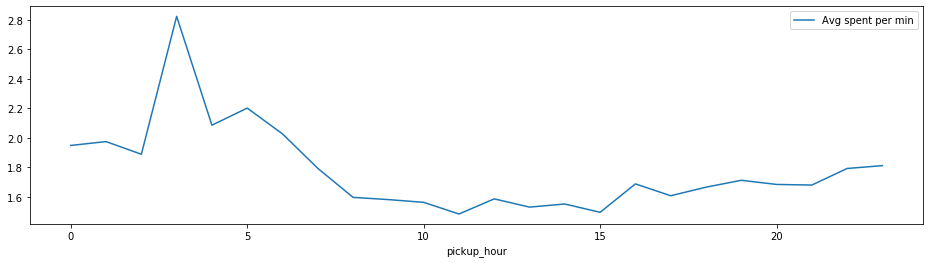

In [28]:
Spent_hour_plot.plot(y='Avg spent per min', x ='pickup_hour',figsize=(16,4))


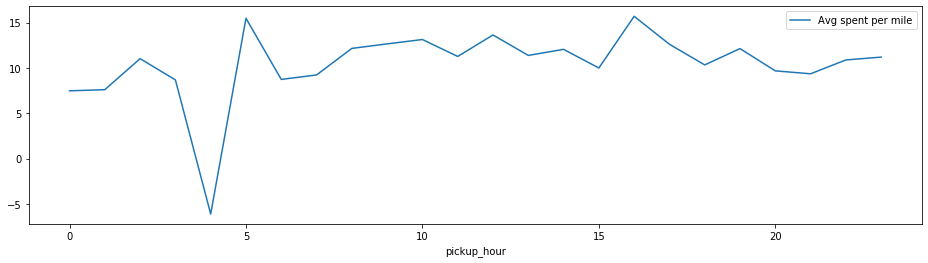

In [25]:
Spent_hour_plot.plot(y='Avg spent per mile',  x ='pickup_hour', figsize=(16,4))

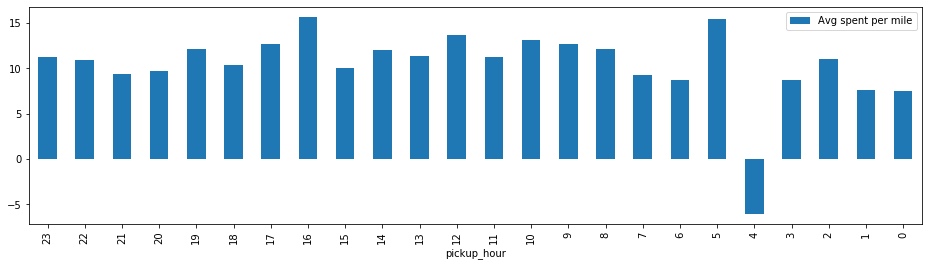

In [26]:
Spent_hour_plot.plot(y='Avg spent per mile',  x ='pickup_hour', kind='bar', figsize=(16,4))
 